# **Dependable AI Project**

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Running&color=red)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/12zKxVdXI6B8n27FWnwlYi_YdZaavCZyI?usp=sharing) 

---
---

# **Design of adversarial patches against ViT and CNNs for Histopatholigcal images**

## **Pytorch Implementation**

## **Dataset Link:** 
*Dataset for Patch training*:  **Histopathologic Cancer Detection** 

[![Dataset](https://img.shields.io/static/v1.svg?logo=kaggle&label=Source&message=Dataset&color=blue)](https://www.kaggle.com/competitions/histopathologic-cancer-detection)

GOAL: Identify metastatic tissue in histopathologic scans of lymph node sections

![References](https://img.shields.io/static/v1.svg?label=Motivation&message=References&color=green)



*   [Adversarial attacks and adversarial
robustness in computational pathology](https://web.archive.org/web/20221010185745id_/https://boris.unibe.ch/173425/1/s41467-022-33266-0.pdf)
*   [Adversarial Patch](https://arxiv.org/pdf/1712.09665.pdf)

---



## **Contributor:** 
*Implemented by: Daya Kumar, Abhijith Sharma*

(Not official, likely to have bugs/errors)


**Code Reference** - [PyTorch | CNN Binary Image Classification by Andrey Shtrauss  ](https://www.kaggle.com/code/shtrausslearning/pytorch-cnn-binary-image-classification)

### Setup 

In [ ]:
#import warnings
#warnings.filterwarnings('ignore')
from __future__ import print_function, division

# Python Utility Library
import os
import sys
import cv2
import copy
import math
import time
import shutil
import tarfile
! pip install timm
import timm
from tqdm import tqdm
from glob import glob
from pathlib import Path

from collections import defaultdict

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
from plotly.subplots import make_subplots
import plotly.graph_objs as go
plt.ion()   # interactive mode

# SciKit Learn Libraries 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Pytorch Generic Libraries
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Subset
from torch.utils.data import RandomSampler
from torch.utils.data.sampler import SubsetRandomSampler

# Pytorch Vision Libraries 
import torchvision
from torchvision import utils
import torchvision.utils as vutils
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torchvision import datasets, models, transforms
from torchvision.models import resnet18, resnet
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Adversarial attack library in PyTorch
! pip install torchattacks
import torchattacks

# Intializing the GPU/CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


%matplotlib inline

# library which allows us to view model summary like keras/tf
!pip install torchsummary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Dataset 
labels_df = pd.read_csv('/content/drive/MyDrive/DAI_Project/Data/train_labels.csv', iterator = False)
print(labels_df.head().to_markdown())

|    | id                                       |   label |
|---:|:-----------------------------------------|--------:|
|  0 | f38a6374c348f90b587e046aac6079959adf3835 |       0 |
|  1 | c18f2d887b7ae4f6742ee445113fa1aef383ed77 |       1 |
|  2 | 755db6279dae599ebb4d39a9123cce439965282d |       0 |
|  3 | bc3f0c64fb968ff4a8bd33af6971ecae77c75e08 |       0 |
|  4 | 068aba587a4950175d04c680d38943fd488d6a9d |       0 |


In [ ]:
# Check target classes are balance 
labels_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [ ]:
# Visualise the dataset 
imgpath ="/content/drive/MyDrive/DAI_Project/Data/train_full/" # training data is stored in this folder # TO CHANGE 
malignant = labels_df.loc[labels_df['label']==1]['id'].values    # get the ids of malignant cases
normal = labels_df.loc[labels_df['label']==0]['id'].values       # get the ids of the normal cases

print('normal ids')
print(normal[0:3],'\n')

print('malignant ids')
print(malignant[0:3])

normal ids
['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08'] 

malignant ids
['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f']


### Data Preparation 

In [ ]:
# In the original Notebook they have defined a custom dataset 
# using only 10,000 images 

torch.manual_seed(0) # fix random seed

class pytorch_data(Dataset):
    
    def __init__(self,data_dir,transform,data_type="train"):      
    
        # Get Image File Names
        cdm_data=os.path.join(data_dir,data_type)  # directory of files
        
        file_names = os.listdir(cdm_data) # get list of images in that directory  
        idx_choose = np.random.choice(np.arange(len(file_names)), 
                                      10000,
                                      replace=False).tolist()
        file_names_sample = [file_names[x] for x in idx_choose]
        self.full_filenames = [os.path.join(cdm_data, f) for f in file_names_sample]   # get the full path to images
        
        # Get Labels
        labels_data=os.path.join(data_dir,"train_labels.csv") 
        labels_df=pd.read_csv(labels_data)
        labels_df.set_index("id", inplace=True) # set data frame index to id
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in file_names_sample]  # obtained labels from df
        self.transform = transform
      
    def __len__(self):
        return len(self.full_filenames) # size of dataset

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # Open Image with PIL
        image = self.transform(image) # Apply Specific Transformation to Image
        return image, self.labels[idx]


In [ ]:
# define transformation that converts a PIL image into PyTorch tensors
# Tensor shape is set to (3,224,224)

import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((224,224))])

# Define an object of the custom dataset for the train folder.
data_dir = '/content/drive/MyDrive/DAI_Project/Data'  # Update based on your path 
img_dataset = pytorch_data(data_dir, data_transformer, "train_subset") # Histopathalogic images

In [ ]:
# load an example tensor
img,label=img_dataset[10]
print(img.shape,torch.min(img),torch.max(img))

#### Split the dataset

In [ ]:
# Split the dataset into train and validation 

len_img=len(img_dataset)
len_train=int(0.8*len_img)
len_val=len_img-len_train

# Split Pytorch tensor
train_ts,val_ts=random_split(img_dataset,
                             [len_train,len_val]) # random split 80/20

print("train dataset size:", len(train_ts))
print("validation dataset size:", len(val_ts))

train dataset size: 8000
validation dataset size: 2000


In [ ]:
# Plot sample images from newly created training set

# Function to plot 
import plotly.express as px

def plot_img(x,y,title=None):

    npimg = x.numpy() # convert tensor to numpy array
    npimg_tr=np.transpose(npimg, (1,2,0)) # Convert to H*W*C shape
    fig = px.imshow(npimg_tr)
    fig.update_layout(template='plotly_white')
    fig.update_layout(title=title,height=300,margin={'l':10,'r':20,'b':10})
    fig.show()

def imshow_cust(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(inp)
    plt.show()
    if title is not None:
    
        plt.title(title)
#    plt.pause(0.001)  # pause a bit so that plots are updated

image indices: [1327 1110 2366 5102 6573 1882   94 6780 2416 7363 4601  492  578 2087
 5014 7058 2211 4188  870 3184 4892 4745 2174 4007 4891 4851 2031 5056
 1580 2787]
torch.Size([3, 680, 2262])



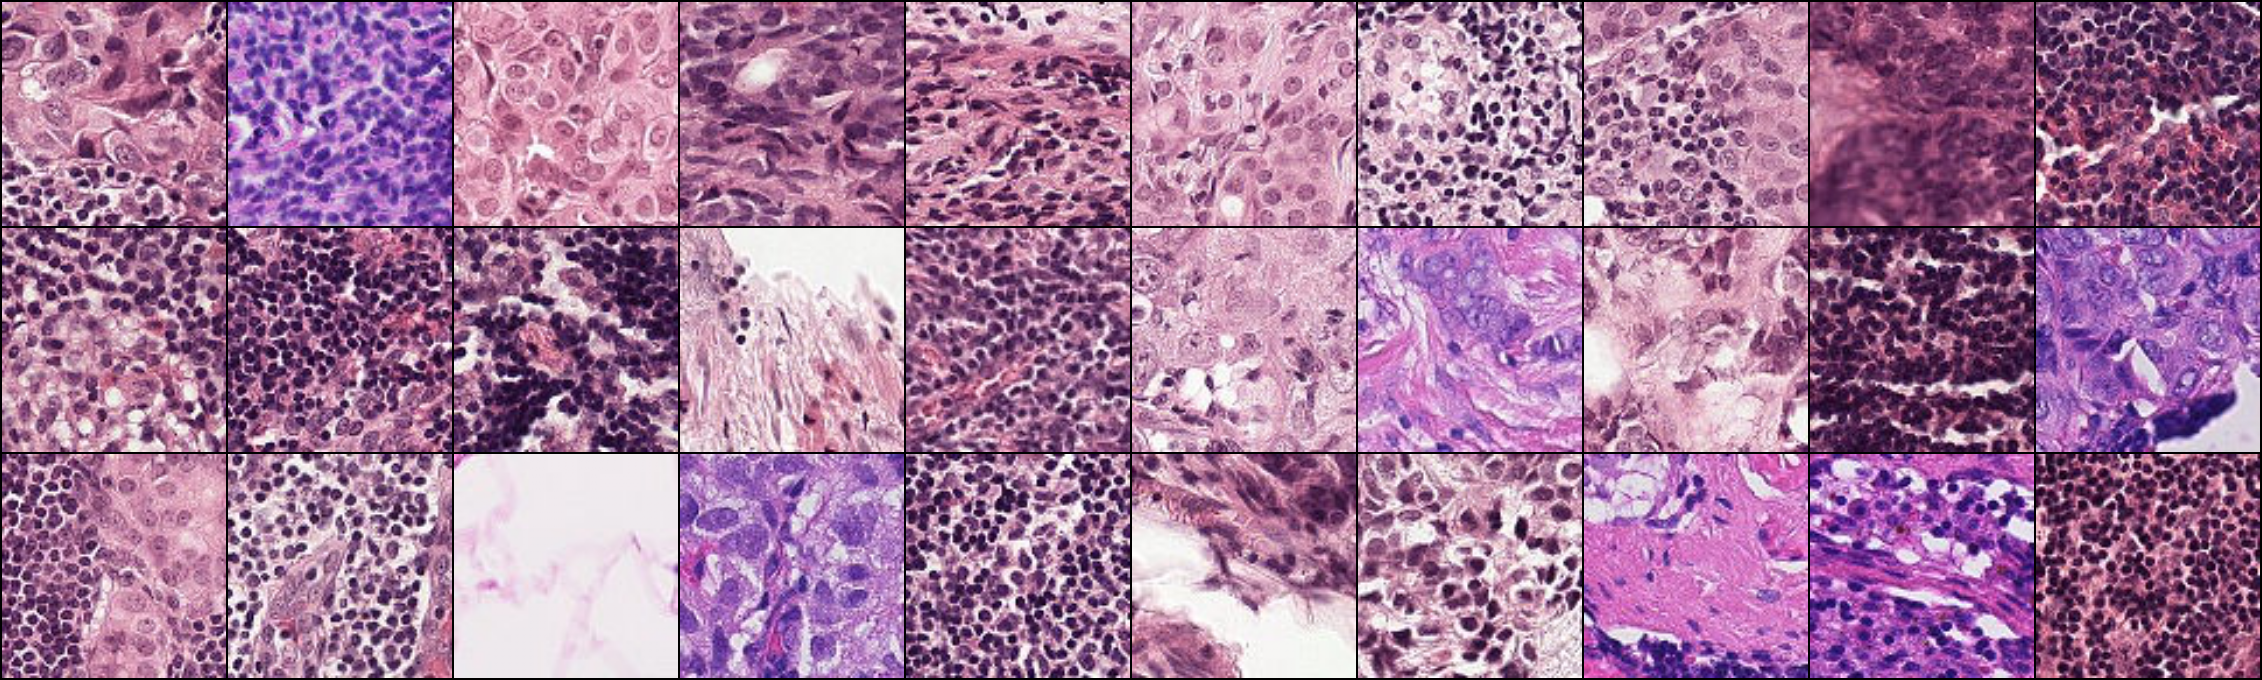

In [ ]:
# Create grid of sample images to visualize the training set 
grid_size=30
rnd_inds=np.random.randint(0,len(train_ts),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ts[i][0] for i in rnd_inds]
y_grid_train=[train_ts[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=10, padding=2)
print(x_grid_train.shape)
    
plot_img(x_grid_train,y_grid_train,'Training Subset Examples')

image indices: [ 205 1168  472  748 1041  995  975  514  399    3  480  534 1007  562
  685   86 1062 1470  390 1835  252  321  251  842  970 1932  247 1456
 1722   22]


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).



torch.Size([3, 680, 2262])



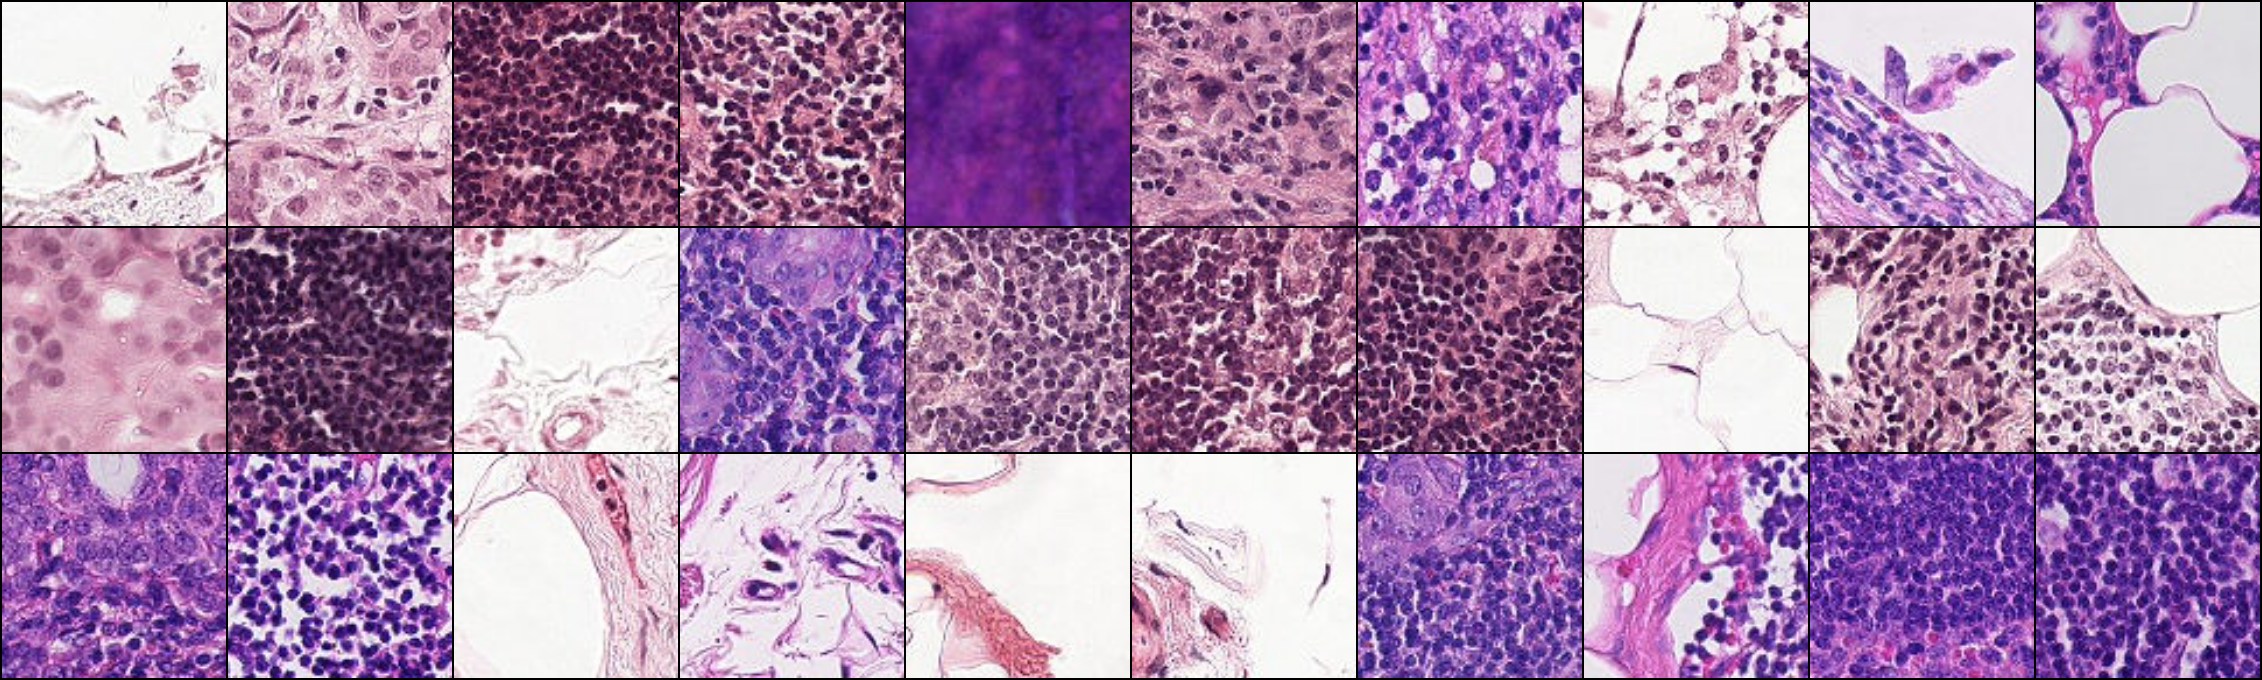

In [ ]:
# # Create grid of sample images to visualize the validation set 

grid_size=30
rnd_inds=np.random.randint(0,len(val_ts),grid_size)
print("image indices:",rnd_inds)
x_grid_val=[val_ts[i][0] for i in range(grid_size)]
y_grid_val=[val_ts[i][1] for i in range(grid_size)]

x_grid_val=utils.make_grid(x_grid_val, nrow=10, padding=2)
print(x_grid_val.shape)

plot_img(x_grid_val,y_grid_val,'Validation Dataset Preview')

#### Data Augmentation 

In [ ]:
# TO CHECK

# Define the following transformations for the training dataset 
tr_transf = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
    transforms.ToTensor()])

# For the validation dataset, we don't need any augmentation; simply convert images into tensors
val_transf = transforms.Compose([
    transforms.ToTensor()])

# After defining the transformations, overwrite the transform functions of train_ts, val_ts
train_ts.transform=data_transformer
val_ts.transform=data_transformer

# The subset can also have transform attribute (if we asign)
train_ts.transform

Compose(
    ToTensor()
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
)

#### Define DataLoaders 

In [ ]:
# Data Loaders 
# Batch_size = 32 

from torch.utils.data import DataLoader

# Training DataLoader
train_dl = DataLoader(train_ts,
                      batch_size=32, 
                      shuffle=True)

# Validation DataLoader
val_dl = DataLoader(val_ts,
                    batch_size=32,
                    shuffle=False)
# check samples
for x,y in train_dl:
    print(x.shape,y)
    break

torch.Size([32, 3, 224, 224]) tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 1])


### ResNet50

In [ ]:
from torch import optim
from torchvision import models
from torch.optim import lr_scheduler

cnn_model = models.resnet50(pretrained=True)
num_ftrs = cnn_model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
cnn_model.fc = nn.Linear(num_ftrs, 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = cnn_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
opt = optim.Adam(cnn_model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 260MB/s]


In [ ]:
''' Helper Functions for training'''

# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

### Training the Model 

In [ ]:
from tqdm.notebook import trange, tqdm

def train_val(model, params,verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    loss_history={"train": [],"val": []} # history of loss values in each epoch
    metric_history={"train": [],"val": []} # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # a deep copy of weights for the best performing model
    best_loss=float('inf') # initialize best loss to a large value
    
    ''' Train Model n_epochs '''
    
    for epoch in tqdm(range(epochs)):
        
        ''' Get the Learning Rate '''
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))
        
        '''
        
        Train Model Process
        
        '''
        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        '''
        
        Evaluate Model Process
        
        '''
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [ ]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 50,
 "optimiser": opt,
 "lr_change": lr_scheduler,
 "f_loss": nn.CrossEntropyLoss(),
 #"f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "/content/drive/MyDrive/DAI_Project/weights_new.pt",
}

''' Actual Train / Evaluation of CNN Model '''
# train and validate the model

cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning:

The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.



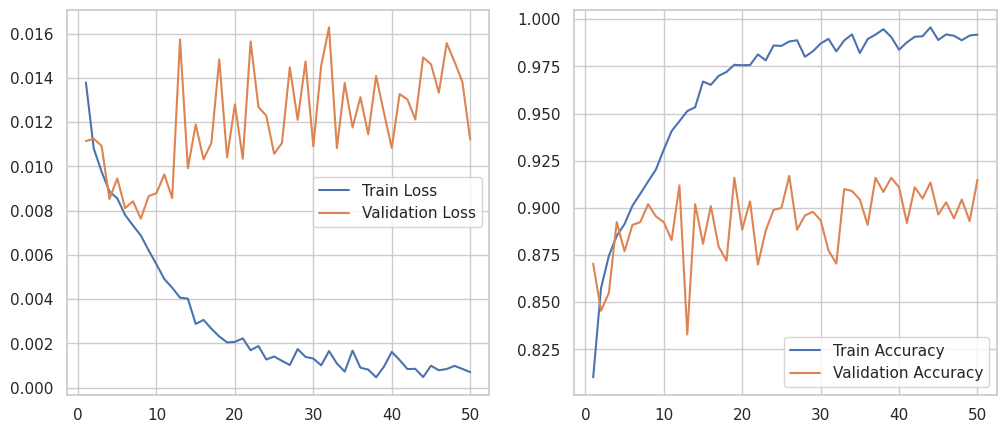

In [ ]:
# Loss and evaluation metric visualization 

import seaborn as sns; sns.set(style='whitegrid')

epochs=params_train["epochs"]

fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='Train Loss')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='Validation Loss')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='Train Accuracy')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='Validation Accuracy')
#plt.title('Convergence History')
plt.show()

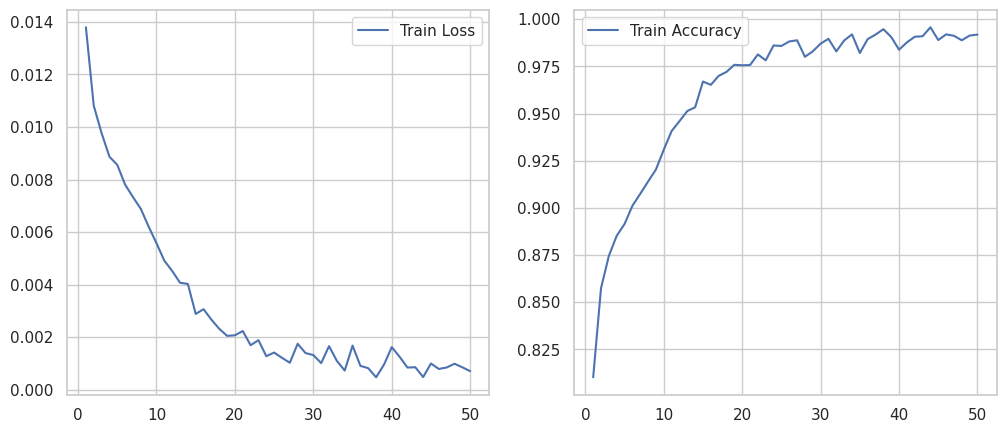

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='Train Loss')
#sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='Validation Loss')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='Train Accuracy')
#sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='Validation Accuracy')
plt.show()

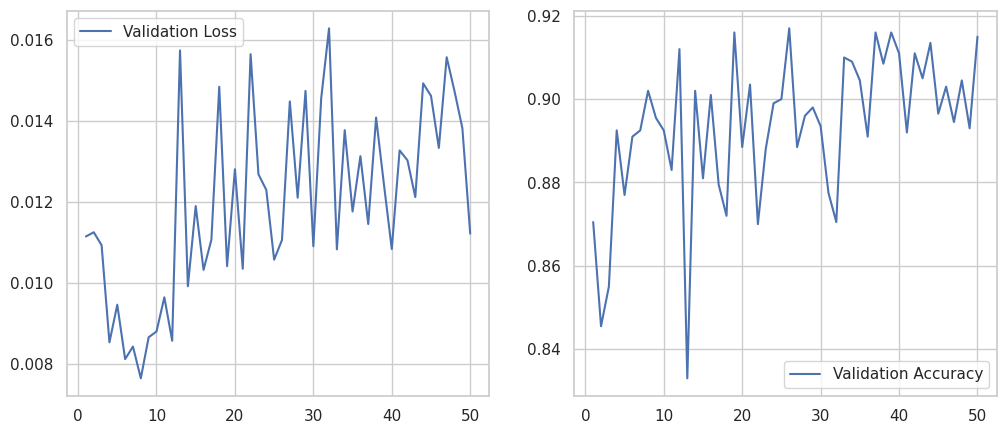

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
#sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='Train Loss')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='Validation Loss')
#sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='Train Accuracy')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='Validation Accuracy')
plt.show()

In [ ]:
# Average accuracy 
train_acc = 0 
val_acc = 0 

for i in metric_hist["train"]:
  train_acc = train_acc + i  

for i in metric_hist["val"]:
  val_acc = val_acc + i 


print('Training Accuracy:', np.round((train_acc/50)*100, 3))
print('Validation Accuracy:', (val_acc/50)*100)

Training Accuracy: 96.282
Validation Accuracy: 89.355


In [ ]:
# Average loss
train_loss = 0 
val_loss = 0 
for i in loss_hist["train"]:
  train_loss = train_loss + i  

for i in loss_hist["val"]:
  val_loss = val_loss + i 


print('Training Loss:', np.round((train_loss/50), 3))
print('Validation Loss:', np.round((val_loss/50), 3))

Training Loss: 0.003
Validation Loss: 0.012


### Inference 

In [ ]:
# Setup Test Dataset 

class pytorchdata_test(Dataset):
    
    def __init__(self, data_dir, transform,data_type="train"):
        
        path2data = os.path.join(data_dir,data_type)
        filenames = os.listdir(path2data)
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        # labels are in a csv file named train_labels.csv
        csv_filename="sample_submission.csv"
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)
        
        # set data frame index to id
        labels_df.set_index("id", inplace=True)
        
        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        self.transform = transform       
        
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx]) # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [ ]:
# load any model weights for the model
cnn_model.load_state_dict(torch.load('/content/drive/MyDrive/DAI_Project/weights.pt'))

<All keys matched successfully>

In [ ]:
# Load Test data 
data_dir = '/kaggle/input/histopathologic-cancer-detection/'

data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46))])

img_dataset_test = pytorchdata_test(data_dir,data_transformer,data_type="test")
print(len(img_dataset_test), 'samples found')

In [ ]:
# Inference 

def inference(model,dataset,device,num_classes=2):
    
    len_data=len(dataset)
    y_out=torch.zeros(len_data,num_classes) # initialize output tensor on CPU
    y_gt=np.zeros((len_data),dtype="uint8") # initialize ground truth on CPU
    model=model.to(device) # move model to device
    
    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y=dataset[i]
            y_gt[i]=y
            y_out[i]=model(x.unsqueeze(0).to(device))

    return y_out.numpy(),y_gt            

y_test_out,_ = inference(cnn_model,img_dataset_test, device)  

In [ ]:
# check class predictions 0,1
y_test_pred=np.argmax(y_test_out,axis=1)
print(y_test_pred.shape)
print(y_test_pred[0:5])

### Mask Design 

In [ ]:
cnn_model.load_state_dict(torch.load('/content/drive/MyDrive/DAI_Project/weights.pt'))
cnn_model = cnn_model.eval()

In [ ]:
trans_totensor = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# m = Image.open("/content/drive/MyDrive/Defense/Mask.jpg")
m = Image.open("/content/drive/MyDrive/DAI_Project/mask.jpg")

convert_tensor = transforms.ToTensor()
mask = trans_totensor((m)).cpu()
#imshow_cust(mask)
mask=mask[None,:]

In [ ]:
for i in range(224):
  for j in range(224):
    if mask[0][0][i][j]>=0.5:
      mask[0][0][i][j]=1
    else:
      mask[0][0][i][j]=0
    
    if mask[0][1][i][j]>=0.5:
      mask[0][1][i][j]=1
    else:
      mask[0][1][i][j]=0

    if mask[0][2][i][j]>=0.5:
      mask[0][2][i][j]=1
    else:
      mask[0][2][i][j]=0

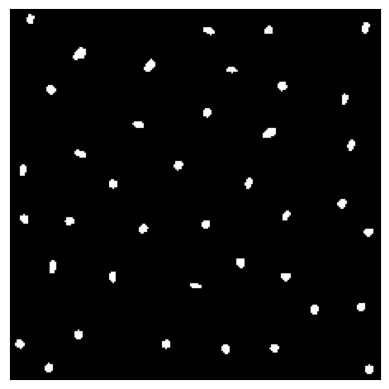

In [ ]:
imshow_cust(mask[0])

### Patch Training 

In [ ]:
# Patch Attack Procedure
def patch_attack_proc(image, patch, mask, cnn_model, ori_class, tar_class, conf):

    cnn_model.eval().to(device)
    # Stopping criteria for optimization
    cond = 1
    target_prob = 0
    criterion = torch.nn.CrossEntropyLoss()
    # Generate artifact from Generator based on updated vector embedding
    flag = 0
    stop = 0
    count = 1
    while(cond or stop<10):
      count = count + 1
      if count%500==0:
        conf = conf - 0.005
      target_prev = target_prob
      # Initializing computation gradient graph for patch training
      patch = Variable(patch, requires_grad=True)
      optimizer = optim.Adam([patch], lr = 0.1)
      optimizer.zero_grad()
      # Creating adversarial image with  patch
      adv_image = torch.mul((1-mask),image) + torch.mul(mask, patch)
      #imshow_old(adv_image[0].detach().cpu())
      # Prediction
      adv_out = cnn_model(adv_image)
      x_out = F.softmax(adv_out)

      # Loss for classifying as target class
      #pred_target = adv_out[0][tar_class]
      # Overall loss
      tc = []
      tc.append(tar_class)
      tar_class = torch.tensor(tc)
      tar_class = tar_class.type(torch.LongTensor).to(device)
      Loss = criterion(adv_out, tar_class)
      # Backprop loss gradient w.r.t adv_image
      Loss.backward()
      # Update embed_vec
      optimizer.step()
      # Clipping patch if in image domain (network domain is free to have any values)
      # TO BE UPDATED AS PER PINK-PURPLE
      embed_vec=torch.clamp(embed_vec, -1, 1)

      # Stopping criteria
      target_prob = x_out.data[0][tar_class]
      cond = target_prob < conf
      if (cond==False):
        stop = stop+1

      if(abs(target_prev-target_prob) <1e-12):
        if flag==10:
          break
        else:
          flag = flag + 1
      count = count+1
    
    return adv_image, patch, target_prob

In [ ]:
def training_loop(MAIN_DIR, patch, mask, CNN_MODEL_NAME, cnn_model, train_loaders, tar_class, Epochs, conf):

  steps=50
  cnn_model.eval()
  success = 0
  nat_total = 0
  flag_count=0
  print("Training patch of target class: ", tar_class)

  for epoch in range(Epochs):
    print("Epoch: ",epoch,"/",Epochs)

    for batch_idx, (image, label) in enumerate(train_loaders):
      
      # Sample image and label from dataset
      # Transfer image to GPU
      image = image.to(device)
      label = label.to(device)
      # Make the image a computational graph
      #image, label = Variable(image), Variable(label)
      image_clean= image
      # Doing prediction on clean data
      cnn_model=cnn_model.to(device)
      prediction = cnn_model(image_clean)
      # only computer adversarial examples on examples that are originally classified correctly
      if prediction.data.max(1)[1][0] != label.data[0]:
        continue
      # Increase the count of natural accuracy
      nat_total += 1
      # Perform Norm based attack if the image belongs to the class for which patch is being trained
      if label.data[0]==tar_class:
        flag_count=flag_count+1
        attack = torchattacks.PGD(cnn_model, eps=norm_tol, alpha=1/255, steps=steps, random_start=True)
        image = attack(image, label)

      image_shape = image.data.cpu().numpy().shape
      # Traning vector embedding for each embedding
      adv_image, embed_vec, target_prob  = patch_attack_proc(image, patch, mask, cnn_model, label.data[0], tar_class, conf)
      adv_label = cnn_model(adv_image).data.max(1)[1][0]
      ori_label = label.data[0]
      if adv_label == tar_class:
        success=success+1
      if (batch_idx%500==0):
        print(batch_idx,"/",len(train_loaders)," Percentage Done: ", int(batch_idx/len(train_loaders)*100),"%")
    print("Total_PGD_attack_counts: ", flag_count)

    # Saving trained
    #TO BE UPDATED AS PER THE DRIVE
    VEC_EMBED_PATH = MAIN_DIR + CNN_MODEL_NAME +'_'+ str(tar_class) +'_'+ str(int(conf*100)) + '.pt'
    torch.save(patch, VEC_EMBED_PATH)


In [ ]:
# Trainloader for training (one image at a time)
# TO BE UPDATED
MAIN_DIR = '/content/'
CNN_MODEL_NAME = 'resnet50'
train_dl = DataLoader(train_ts, batch_size=1, shuffle=True)
norm_tol = 0/255
Epochs = 1
conf = 0.95
tar_class = 0
# INITIALIZE PATCH WITH PURPLE COLOR
patch = torch.zeros((1,3,224,224))

# TRAINING LOOP
training_loop(MAIN_DIR, patch, mask, CNN_MODEL_NAME, cnn_model, train_dl, tar_class, Epochs, norm_tol, conf)

### Patch Testing 

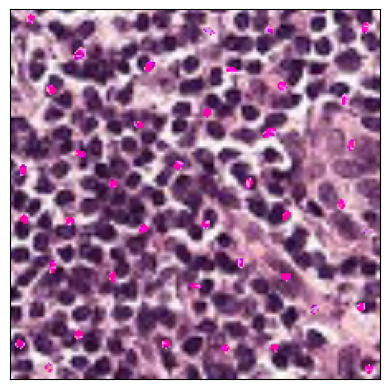

In [ ]:
image,label = next(iter(val_dl))
MAIN_DIR = '/content/drive/MyDrive/DAI_Project/'
CNN_MODEL_NAME = 'resnet50'
train_dl = DataLoader(train_ts, batch_size=1, shuffle=True)
norm_tol = 0/255
Epochs = 1
conf = 0.95
tar_class = 0
val_dl = DataLoader(val_ts, batch_size=1, shuffle=False)

patch = torch.load(MAIN_DIR + CNN_MODEL_NAME +'_'+ str(tar_class) +'_'+ str(int(conf*100)) + '.pt')
patch = patch.to(device)
image = image.to(device)
mask = mask.to(device)
adv_image = torch.mul((1-mask),image) + torch.mul(mask, patch)
imshow_cust(adv_image[0].detach().cpu())

In [ ]:
def testing_loop(patch, mask, cnn_model, test_loaders):

  cnn_model.eval()
  success1 = 0
  success2 = 0
  nat_total = 0

  for batch_idx, (image, label) in enumerate(test_loaders):
    # Sample image and label from dataset
    # Transfer image to GPU
    image = image.to(device)
    label = label.to(device)
    # Doing prediction on clean data
    cnn_model = cnn_model.to(device)
    nat_total += 1
    ori_label = cnn_model(image).data.max(1)[1][0]
    if ori_label == label:
      success1=success1+1
    # Perform Norm based attack if the image belongs to the class for which patch is being trained
    adv_image = torch.mul((1-mask),image) + torch.mul(mask, patch)
    adv_label = cnn_model(adv_image).data.max(1)[1][0]
    ori_label = label.data[0]
    if adv_label == label:
      success2=success2+1

  print("Test Accuracy pre-attack: ", int(success1/nat_total*100))  
  print("Test Accuracy post-attack: ", int(success2/nat_total*100))

In [ ]:
testing_loop(patch, mask, cnn_model, val_dl)

Test Accuracy pre-attack:  92
Test Accuracy post-attack:  69


## Final Test with morphed Adversarial Images 

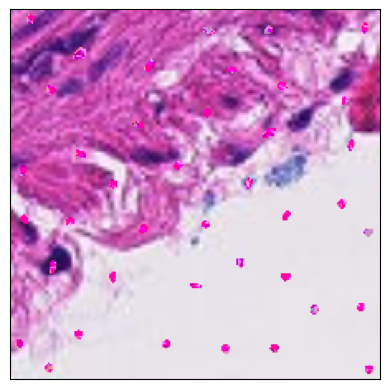

In [ ]:
image,label = next(iter(val_dl))
MAIN_DIR = '/content/drive/MyDrive/DAI_Project/'
CNN_MODEL_NAME = 'resnet50'
train_dl = DataLoader(train_ts, batch_size=1, shuffle=True)
norm_tol = 0/255
Epochs = 1
conf = 0.95
tar_class = 0
val_dl = DataLoader(val_ts, batch_size=1, shuffle=False)

# Print sample adversarial image 

patch = torch.load(MAIN_DIR + CNN_MODEL_NAME +'_'+ str(tar_class) +'_'+ str(int(conf*100)) + '.pt')
patch = patch.to(device)
image = image.to(device)
mask = mask.to(device)
adv_image = torch.mul((1-mask),image) + torch.mul(mask, patch)
imshow_cust(adv_image[0].detach().cpu())

In [ ]:
# FINAL FUNCTION CODE 

# Final code for function for morphing the images 
from google.colab.patches import cv2_imshow


def tensor_morph(img1, img2, kernel_size = 1):

  
    # Extract the images from GPU 
    img1 = np.transpose(img1.detach().cpu().numpy(), (1, 2, 0))
    img2 = np.transpose(img2.detach().cpu().numpy(), (1, 2, 0))

    # Convert the images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Define the kernel size for morphological operations
    kernel_size = kernel_size
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    # Apply morphological operations to obtain the difference between the images
    diff = cv2.absdiff(gray1, gray2)
    diff = cv2.threshold(diff, 0.1, 255, cv2.THRESH_BINARY)[1]
    diff = cv2.morphologyEx(diff, cv2.MORPH_OPEN, kernel)

    # Create a mask for the morphed image
    mask = np.zeros(img1.shape, dtype=np.uint8)
    mask[diff==255] = 1

    # Create morphed adversarial image
    m1 = cv2.multiply(img1, mask, dtype = cv2.CV_32F)
    m2 = cv2.multiply(img2, 1 - mask, dtype = cv2.CV_32F)
    morph_image = m1 + m2

  

    return morph_image

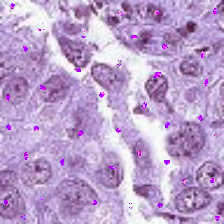

In [ ]:
# Test that the code for morphing the images works 

adv_image_morphed = tensor_morph(image[11], adv_image[11], kernel_size=5) # Batch of morphed adv images 

view_morph_image= (adv_image_morphed * 255).astype(np.uint8) # rescale to [0, 255] and convert to uint8

# visualize grayscale image
cv2_imshow(view_morph_image)

#### Test model accuracy for different kernal sizes 
Change Kernal size in the function call `tensor_morph` to test for that particular size. 

In [ ]:
MAIN_DIR = '/content/drive/MyDrive/DAI_Project/'
CNN_MODEL_NAME = 'resnet50'
train_dl = DataLoader(train_ts, batch_size=1, shuffle=True)
norm_tol = 0/255
Epochs = 1
conf = 0.95
tar_class = 0
val_dl = DataLoader(val_ts, batch_size=1, shuffle=False)

patch = torch.load(MAIN_DIR + CNN_MODEL_NAME +'_'+ str(tar_class) +'_'+ str(int(conf*100)) + '.pt')
patch = patch.to(device)
mask = mask.to(device)
    

In [ ]:
def testing_loop(patch, mask, cnn_model, test_loaders):

  cnn_model.eval()
  success1 = 0
  success2 = 0
  nat_total = 0

  for batch_idx, (image, label) in enumerate(test_loaders):
    # Sample image and label from dataset
    # Transfer image to GPU
    image = image.to(device)
    label = label.to(device)
    
    # Doing prediction on clean data
    cnn_model = cnn_model.to(device)
    nat_total += 1
    ori_label = cnn_model(image).data.max(1)[1][0]
    if ori_label == label:
      success1=success1+1
    # Perform Norm based attack if the image belongs to the class for which patch is being trained
    adv_image_true = torch.mul((1-mask),image) + torch.mul(mask, patch) 
    adv_image_morphed = tensor_morph(image.squeeze(0), adv_image_true.squeeze(0), kernel_size=3) # CHANGE SIZE HERE 
    adv_image_morphed_T = torch.from_numpy(adv_image_morphed).permute(2, 0, 1).unsqueeze(0) # Convert to tensor of right shape 
    adv_image_morphed_T = adv_image_morphed_T.to(device) # Check if this is needed. 
    adv_label = cnn_model(adv_image_morphed_T).data.max(1)[1][0]
    ori_label = label.data[0]
    if adv_label == label:
      success2=success2+1
    

  print("Test Accuracy pre-attack: ", int(success1/nat_total*100))  
  print("Test Accuracy post-attack: ", int(success2/nat_total*100))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

testing_loop(patch, mask, cnn_model, val_dl)

Test Accuracy pre-attack:  93
Test Accuracy post-attack:  91
